In [1]:
import sys

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra.datasets
from cebra import CEBRA
import cebra

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(DEVICE)

cuda


In [3]:
cortex = 'VISpm'
seed=333
num_neurons = 800

ca_train = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-train-10-{seed}')
#np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
#joint_train = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')

ca_test = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-test-10-{seed}')
#np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')
#joint_test = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')


(-47.03983612060547, 43.14802856445313, -52.48082580566406, 44.507330322265624)

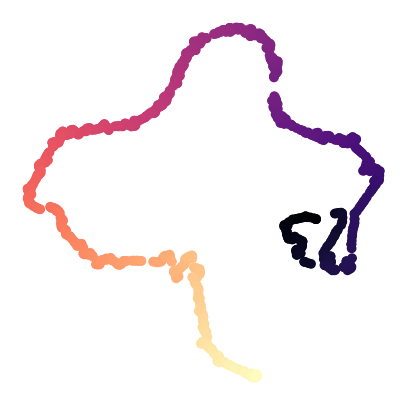

In [4]:
ca_train

dino_tsne = TSNE(n_components = 2)
dino_tsne_viz = dino_tsne.fit_transform(ca_train.index[:900,:])

fig = plt.figure(figsize = (5,5))
plt.scatter(dino_tsne_viz[:,0], dino_tsne_viz[:,1], cmap = 'magma', c = np.arange(900))
plt.axis('off')

In [7]:
print(ca_train.index.shape)
print(ca_test.index.shape)

torch.Size([8100, 768])
torch.Size([900, 768])


In [4]:
train_steps = 10000
ca_loader = cebra.data.ContinuousDataLoader(ca_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset =1)

In [9]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    data_loader.to(kwargs['device'])
    model = cebra.models.init(kwargs['model_architecture'], data_loader.dataset.input_dimension,
                              kwargs['num_hidden_units'],
                              kwargs['output_dimension'], norm).to(kwargs['device'])
    data_loader.dataset.configure_for(model)
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            tqdm_on=kwargs['verbose'])


@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    dataset.configure_for(model)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [10]:
cebra_ca = single_session_solver(data_loader = ca_loader, model_architecture = 'offset1-model',
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)
DEVICE

'cuda'

In [11]:
cebra_ca.fit(ca_loader)
cebra_ca_emb = _compute_emissions_single(cebra_ca, ca_train)

pos: -0.9989 neg:  6.2783 total:  5.2794 temperature:  1.0000: 100%|██████████| 10000/10000 [02:47<00:00, 59.54it/s]


In [12]:
print(cebra_ca_emb.shape)

(8100, 128)


(-0.18396524116396903,
 0.17747335657477378,
 -0.284284833073616,
 0.21222931444644927)

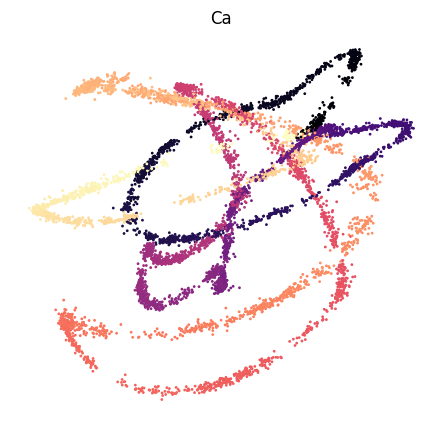

In [13]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Ca')
ax1.scatter(cebra_ca_emb[:,0], cebra_ca_emb[:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')


In [14]:
def allen_frame_id_decode(train_fs, train_labels, test_fs, test_labels, modality = 'neuropixel', decoder = 'knn'):

    if modality == 'neuropixel':
        FACTOR = 4
    elif modality == 'ca':
        FACTOR = 1

    time_window = 1

    def feature_for_one_frame(feature):
        if isinstance(feature, torch.Tensor):
            feature = feature.cpu().numpy()
        return feature.reshape(-1,FACTOR,feature.shape[-1]).mean(axis = 1)

    train_fs = feature_for_one_frame(train_fs)
    test_fs = feature_for_one_frame(test_fs)


    if train_fs is None or test_fs is None:
        return [None], [None], None
    if decoder == 'knn':
        params = np.power(np.linspace(1, 10, 5, dtype=int), 2)
    elif decoder == 'bayes':
        params = np.logspace(-9, 3, 5)
    else:
        raise ValueError('Choose decoder between knn or bayes')
    errs = []

    for n in params:
        if decoder == 'knn':
            train_decoder = KNeighborsClassifier(n_neighbors=n,
                                                     metric='cosine')
        elif decoder == 'bayes':
            train_decoder = GaussianNB(var_smoothing = n)
        train_valid_idx = int(len(train_fs)/9*8)
        train_decoder.fit(train_fs[:train_valid_idx], train_labels[:train_valid_idx])
        pred = train_decoder.predict(train_fs[train_valid_idx:])
        err = train_labels[train_valid_idx:] - pred
        errs.append(abs(err).sum())

    if decoder == 'knn':
        test_decoder = KNeighborsClassifier(n_neighbors=params[np.argmin(errs)],
                                                     metric='cosine')
    elif decoder == 'bayes':
        test_decoder = GaussianNB(var_smoothing = params[np.argmin(errs)])

    test_decoder.fit(train_fs, train_labels)
    pred = test_decoder.predict(test_fs)
    frame_errors = pred - test_labels

    def _quantize_acc(frame_diff, time_window=1):

        true = (abs(frame_diff) < (time_window * 30)).sum()

        return true / len(frame_diff) * 100

    quantized_acc = _quantize_acc(frame_errors, time_window)

    return pred, frame_errors, quantized_acc

In [18]:
cebra_ca_test= _compute_emissions_single(cebra_ca, ca_test)
pred_cebra, errs_cebra ,acc_cebra = allen_frame_id_decode(cebra_ca_emb, np.tile(np.arange(900), 9), cebra_ca_test, np.arange(900), modality = 'ca', decoder = 'knn')

In [19]:
acc_cebra

61.33333333333333

In [20]:
errs_cebra

array([ 896,  888,  893,  889,  862,  889,   10,    4,  147,  889,    3,
          6,  -11,  881,    1,  881,  -11,   -1,  801,  880,    0,    7,
         20,    5,   24,   20,   10,   29,   -6,    7,   12,    5,    7,
        -12,  -13,  259,   18,    3,    6,   21,    3,   12,    3,    6,
          5,    4,   12,    1,   12,    1,   10,  -32,    0,  -11,  -10,
        -25,  -16,  -20,   -9,  583,  739,   -1,  677,  -18,   57,  -20,
        -16,  543,  -29,  -27,   19,  206,  731,  -27,   75,  -70,  663,
        182,  152,  187,  690,  103,   31,  139,   55,  -24,  -48,  -67,
        -24,  -12,  -28,   -4,    1,  -33,  -27,  -32,  514,   -6,  705,
        733,  -80,  -62,  -40,  -29,    1,  -66,  690,  -28,  -46,   -4,
        -47,  -32,    4,   -5,    2,  -20,   15,  -78,    1,  620,  684,
         -5,   -4,  601,   -5,  594,  642,  624,  649,  -16,  625,  648,
        587,  670,  564,  -71,  -25,  599,   24,   -5, -121,  -22,  645,
         37,  -26,   -9,  -33,  131,  749,  -38,   

pos: -0.9969 neg:  6.2751 total:  5.2782 temperature:  1.0000: 100%|██████████| 10000/10000 [02:29<00:00, 66.67it/s]


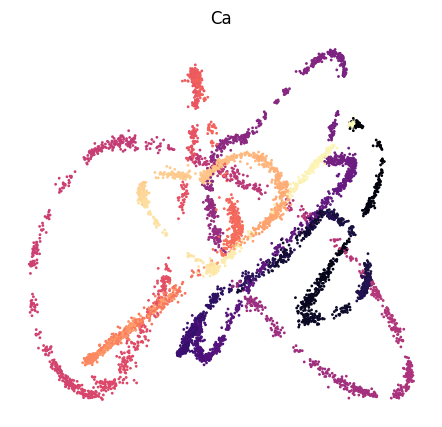

75.66666666666667

In [21]:
from pipeline import run_pipeline

exps={'cortex': 'VISp','seed':333,'num_neurons':800}

run_pipeline(**exps)